# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Let's play some old videogames
![img](https://s17.postimg.org/y9xcab74f/nerd.png)

This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [2]:
from gym.core import ObservationWrapper
from gym.spaces import Box

from PIL import Image


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _observation(self, img):
        """what happens to each observation"""
        
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size 
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        min_x = 10
        max_x = 150
        min_y = 32
        max_y = 193
        pil_img = Image.fromarray(img[min_y:max_y,min_x:max_x,0])
        pil_img = pil_img.resize((self.img_size[1], self.img_size[2]))
        pil_img = pil_img.convert('L')
        res = np.array(pil_img.getdata(), dtype=np.float32) / 255
        res = res.reshape(self.img_size)
        return res

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: <class '__main__.PreprocessAtari'> doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method.
Formal tests seem fine. Here's an example of what you'll get.


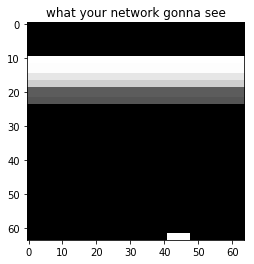

In [3]:
import gym
#spawn game instance for tests
env = gym.make("BreakoutDeterministic-v0") #create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

env.reset()
obs, _, _, _ = env.step(env.action_space.sample())


#test observation
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[0, :, :],interpolation='none',cmap='gray');



### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to fing optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [4]:
from framebuffer import FrameBuffer
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


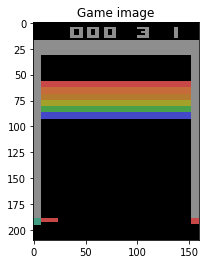

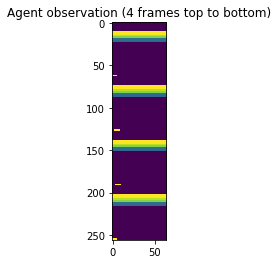

In [5]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_dim[2]]));

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://s17.postimg.org/815l39kan/dqn_arch.png)

In [6]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [7]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        """A simple DQN agent"""
        nn.Module.__init__(self)
        self.epsilon = epsilon
        self.n_actions = n_actions
        img_c, img_w, img_h = state_shape
        
        # Define your network body here. Please make sure agent is fully contained here
        
        def get_length(x):
            return (((x + 1) // 2 + 1) // 2 + 1) // 2
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_c, 16, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.ReLU(),
        ).cuda()
        
        self.linear_layers = nn.Sequential(
            nn.Linear(get_length(img_w) * get_length(img_h) * 64, 256),
            nn.ReLU(),
            nn.Linear(256, self.n_actions)
        ).cuda()
            

    def forward(self, state_t):
        """
        takes agent's observation (Variable), returns qvalues (Variable)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        Hint: if you're running on GPU, use state_t.cuda() right here.
        """
        
        # Use your network to compute qvalues for given state
        conv_out = self.conv_layers(state_t.cuda())
        qvalues = self.linear_layers(conv_out.view(conv_out.size(0), -1))
        
        assert isinstance(qvalues, Variable) and qvalues.requires_grad, "qvalues must be a torch variable with grad"
        assert len(qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions
        
        return qvalues
    
    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not Variables
        """
        states = Variable(torch.FloatTensor(np.asarray(states)))
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [11]:
agent = DQNAgent(state_dim, n_actions, epsilon=1)

/usr/lib/python3.6/site-packages/torch/cuda/__init__.py:97: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Now let's try out our agent to see if it raises any errors.

In [8]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [33]:
evaluate(env, agent, n_games=1)

1.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here __to get 2 bonus points__.

![img](https://s17.postimg.org/ms4zvqj4v/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [9]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) == self._maxsize:
            del self._storage[0]
        self._storage.append(data)
        
    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = random.sample(range(len(self._storage)), min(batch_size, len(self._storage)))
        states, actions, rewards, next_states, is_done = zip(*[self._storage[idx] for idx in idxes])
        
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(is_done)

In [35]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [10]:
def play_and_record(agent, env, exp_replay, n_steps=1, s0=None, s1=None):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.
    :returns: return average reward over time
    """

    # Play the game for n_steps as per instructions above
    if s0 is None:
        state = env.reset()
    else:
        state = s0
    total_reward = []
    for i in range(n_steps):
        action = agent.sample_actions(agent.get_qvalues(state.reshape((1, 4, 64, 64))))[0]
        next_state, reward, done, _ = env.step(action)
        
        exp_replay.add(state, action, reward, next_state, done)
        state = next_state
        if s1 is not None:
            s1 = state
        
        total_reward.append(reward)
        
        if done:
            state = env.reset()
    
    return np.mean(total_reward)

In [37]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://s17.postimg.org/x3hcoi5q7/taget_net.png)



In [38]:
target_network = DQNAgent(state_dim, n_actions)

In [39]:
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.
__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [40]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma = 0.99, check_shapes = False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = Variable(torch.FloatTensor(states))    # shape: [batch_size, c, h, w]
    actions = Variable(torch.LongTensor(actions))    # shape: [batch_size]
    rewards = Variable(torch.FloatTensor(rewards))  # shape: [batch_size]
    next_states = Variable(torch.FloatTensor(next_states)) # shape: [batch_size, c, h, w]
    is_done = Variable(torch.FloatTensor(is_done.astype('float32')))  # shape: [batch_size]
    is_not_done = 1 - is_done
    
    #get q-values for all actions in current states
    predicted_qvalues = agent(states)
    
    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    #select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[torch.from_numpy(np.arange(len(states))).cuda(),
                                                      actions.cuda()]
    

    # compute V*(next_states) using predicted next q-values
    next_state_values = target_network(next_states).max(1)[0]
    
    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards.cuda() + is_not_done.cuda() * next_state_values
    
    #mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2 )
    
    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"
    
    return loss

In [41]:
# sanity checks
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, gamma=0.99,
                       check_shapes=True)
loss.backward()

assert isinstance(loss, Variable) and tuple(loss.data.size()) == (1,), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.cpu().data.numpy() != 0), "loss must be differentiable w.r.t. network weights"

### Main loop

It's time to put everything together and see if it learns anything.

In [42]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import ewma
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [43]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000);

In [44]:
opt = torch.optim.Adam(agent.parameters())

buffer size = 100000, epsilon = 0.04303
TD loss = 1.979287


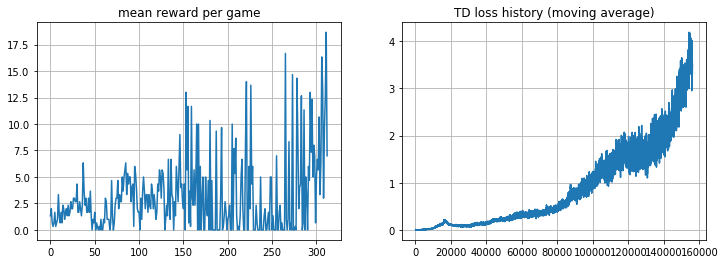

Win!


 26%|██▌       | 155998/600000 [1:40:25<4:45:50, 25.89it/s]

In [45]:
s0 = env.reset()
for i in trange(6 * 10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10, s0, s0)
    
    # train
    data = exp_replay.sample(64)
    
    opt.zero_grad()
    loss = compute_td_loss(*data)
    loss.backward()
    opt.step()
    
    td_loss_history.append(loss.data.cpu().numpy()[0])
    
    # adjust agent parameters
    if i % 500 == 0:
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        
        #Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())
        
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        print('TD loss = %.6f' % td_loss_history[-1])
        plt.figure(figsize=[12, 4])        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(pd.ewma(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()
        
        if len(mean_rw_history) > 10 and np.mean(mean_rw_history[-10:]) > 10:
            print("Win!")
            break        

In [46]:
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")

That's good enough for tutorial.


In [53]:
torch.save(agent.state_dict(), 'agent_model')

__ How to interpret plots: __


This aint no supervised learning so don't expect anything to improve monotonously. 
* __ TD loss __ is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* __ mean reward__ is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 5-10k steps to "warm up" agent before it starts to get better.
* __ buffer size__ - this one is simple. It should go up and cap at max size.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Also please ignore first 100-200 steps of each plot - they're just oscillations because of the way moving average works.

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's gonna start winning (average reward > 10) after 20k steps. 

But hey, look on the bright side of things:

![img](https://s17.postimg.org/hy2v7r8hr/my_bot_is_training.png)

### Video

In [12]:
agent.load_state_dict(torch.load('agent_model'))

In [13]:
agent.epsilon=0 # Don't forget to reset epsilon back to previous value if you want to go on training

In [14]:
#record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(100)]
env_monitor.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices